In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline

import cartopy as cy
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [4]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
areacello = ds_dict[list(ds_dict.keys())[0]]

In [6]:
areacello = areacello.squeeze()

In [7]:
BSarea = areacello.areacello.where(areacello.latitude>66)

Data seaice:

In [8]:
R_fSI='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
R_fSI=s3.glob(R_fSI)

R_fSIi='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_19*.nc'
R_fSIi=s3.glob(R_fSIi)

In [9]:
fileset = [s3.open(file) for file in R_fSI]
dSI = xr.open_mfdataset(fileset, combine='by_coords')

fileset = [s3.open(file) for file in R_fSIi]
dSIi = xr.open_mfdataset(fileset, combine='by_coords')

Data plankton:

In [10]:
R_ch20='s3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
R_ch20=s3.glob(R_ch20)

R_ch19='s3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_19*.nc'
R_ch19=s3.glob(R_ch19)

In [11]:
fileset = [s3.open(file) for file in R_ch20]
dch20 = xr.open_mfdataset(fileset, combine='by_coords')

fileset = [s3.open(file) for file in R_ch19]
dch19 = xr.open_mfdataset(fileset, combine='by_coords')

Radiation: 

In [12]:
R_r20='s3://escience2022/Ada/monthly/rsntds_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
R_r20=s3.glob(R_r20)

R_r19='s3://escience2022/Ada/monthly/rsntds_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_19*.nc'
R_r19=s3.glob(R_r19)

In [13]:
fileset = [s3.open(file) for file in R_r20]
r20= xr.open_mfdataset(fileset, combine='by_coords')

fileset = [s3.open(file) for file in R_r19]
r19 = xr.open_mfdataset(fileset, combine='by_coords')

Zooplankton:

In [14]:
R_z19='s3://escience2022/Ada/monthly/zoocos_Omon_NorESM2-LM_omip1_r1i1p1f1_gr_19*.nc'
R_z19=s3.glob(R_z19)

R_z20='s3://escience2022/Ada/monthly/zoocos_Omon_NorESM2-LM_omip1_r1i1p1f1_gr_20*.nc'
R_z20=s3.glob(R_z20)

In [15]:
fileset = [s3.open(file) for file in R_z19]
z19 = xr.open_mfdataset(fileset, combine='by_coords')

fileset = [s3.open(file) for file in R_z20]
z20 = xr.open_mfdataset(fileset, combine='by_coords')

## Anamoly 

Seaice: 

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


Text(0.5, 1.0, 'Anamoly between sea ice consentration 1900-1920 and 2000-2020')

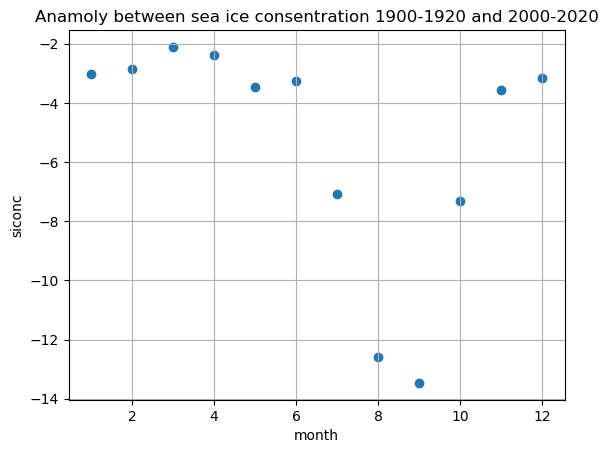

In [16]:
d20= dSI.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.month').mean(dim='time')
d19 = dSIi.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time')
anm = (d20.groupby('month') - d19)
anm = anm.where((d19.latitude>66))
anm = (BSarea*anm).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))
anm.plot.scatter(x='month', y='siconc')
plt.grid()
plt.title('Anamoly between sea ice consentration 1900-1920 and 2000-2020')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,
/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


Text(0.5, 1.0, 'Anamoly between phytoplankton consentration 1900-1920 and 2000-2020')

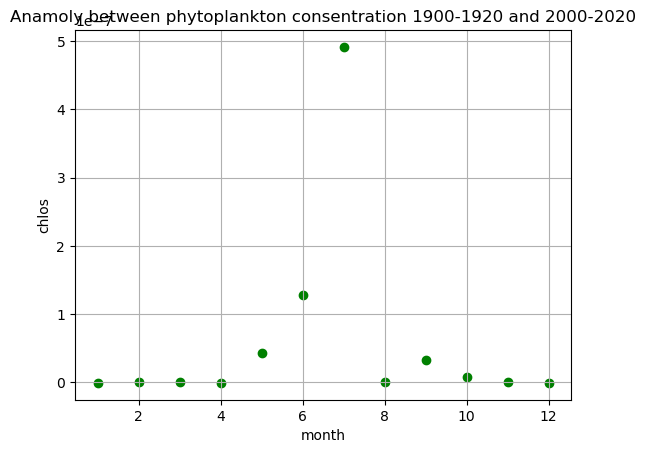

In [17]:
p20= dch20.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.month').mean(dim='time')
p19 = dch19.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time')
anmC = (p20.groupby('month') - p19)
anmC = anmC.where((dch19.latitude>66))
anmC = (BSarea*anmC).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))
anmC.plot.scatter(x='month', y='chlos', color='g')
plt.grid()
plt.title('Anamoly between phytoplankton consentration 1900-1920 and 2000-2020')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


Text(0.5, 1.0, 'Anamoly downward radiation 1900-1920 and 2000-2020')

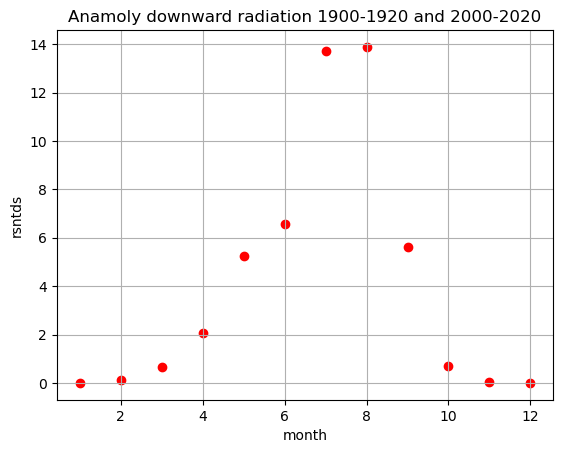

In [18]:
ra20= r20.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.month').mean(dim='time')
ra19 = r19.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time')
anmR = (ra20.groupby('month') - ra19)
anmR = anmR.where((ra19.latitude>66))
anmR = (BSarea*anmR).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))
anmR.plot.scatter(x='month', y='rsntds', color='r')
plt.grid()
plt.title('Anamoly downward radiation 1900-1920 and 2000-2020')

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


Text(0.5, 1.0, 'Change in zooplankton 1900-1920 and 2000-2020')

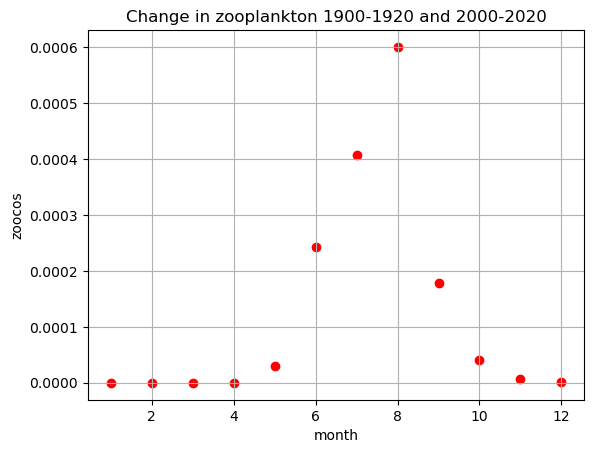

In [19]:
za20= z20.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.month').mean(dim='time')
za19 = z19.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time')
anmZ = (za20.groupby('month') - za19)
anmZ = anmZ.where((za19.latitude>66))
anmZ = (BSarea*anmZ).sum(dim=('i','j'))/BSarea.sum(dim=('i','j'))
anmZ.plot.scatter(x='month', y='zoocos', color='r')
plt.grid()
plt.title('Change in zooplankton 1900-1920 and 2000-2020')

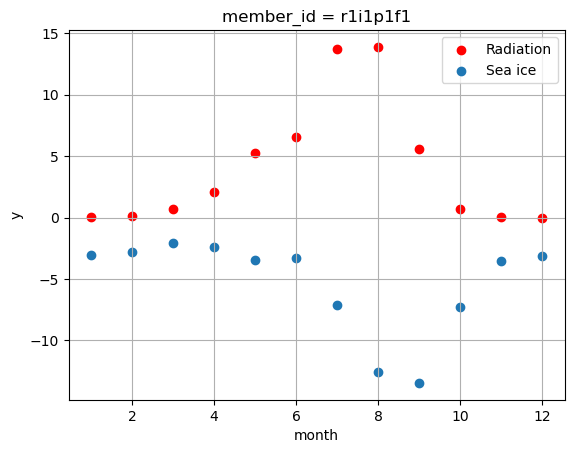

In [20]:
anmR.plot.scatter(x='month', y='rsntds', color='r', label='Radiation')
anm.plot.scatter(x='month', y='siconc', label='Sea ice')
plt.grid()
plt.ylabel('y')
plt.legend()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


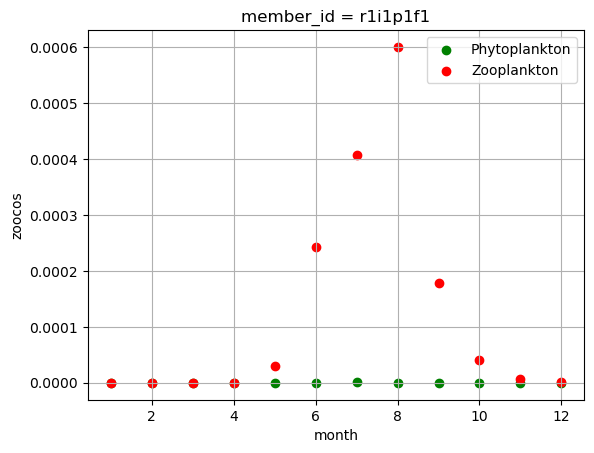

In [21]:
anmC.plot.scatter(x='month', y='chlos',color='g', label='Phytoplankton')
anmZ.plot.scatter(x='month', y='zoocos', color='r', label='Zooplankton')
plt.grid()
plt.legend()